# Quantitative Analysis and Statistical Tests

In [33]:
import pandas as pd
import statistics
from scipy.stats import f_oneway, bartlett, levene
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pingouin
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='white', rc={"grid.linewidth": 0.1})
sns.set_context("paper", font_scale=0.9)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [34]:
# load data
ted = pd.read_csv('../data/processed/ted_measures.csv')

## Assign talks to 4 time periods

16 years of data split it as follows

1. First set - 2006, 2007, 2008, 2009
2. Second set - 2010, 2011, 2012, 2013
3. Third set - 2014, 2015, 2016, 2017
4. Fourth set - 2018, 2019, 2020, 2021

In [35]:
# divide the talks into 4 time periods

def to_tp(x):

    if x in [2006, 2007, 2008, 2009]:
        return 1
    elif x in [2010, 2011, 2012, 2013]:
        return 2
    elif x in [2014, 2015, 2016, 2017]:
        return 3
    else:
        return 4

ted['time_period'] =ted['p_year'].apply(to_tp)

In [36]:
ted['time_period'].value_counts()

4    930
2    898
3    838
1    453
Name: time_period, dtype: int64

## Hypotheses Testing

Test different hypotheses.

1. Are there statistically significant differences between different time periods for the measures computed? => ANOVA
2. If yes, where do they differences lie?
    - Can Tukey's HSD be used?
    - If not, what else to use?

Significance level chosen : 5%

In [37]:
# measures
meas = ['mws', 'fkl', 'mtld', 'pm_i', 'pm_we', 'pm_you', 'lf', 'spm', 'nip']

# significance level
alpha = 0.05

In [38]:
# helper functions

def cnt_outliers(df, feature):

    iqr = stats.iqr(df[feature], interpolation='midpoint')
    out = [point for point in df[feature].values if (point > Q3+1.5*iqr) or (point < Q1-1.5*iqr)]

    return (len(out))

def split_time(df, col):

    periods = [1,2,3,4]
    temp = df[[col, 'time_period']]
    op = (list(temp[temp['time_period'] == 1][col].values),
          list(temp[temp['time_period'] == 2][col].values),
          list(temp[temp['time_period'] == 3][col].values),
          list(temp[temp['time_period'] == 4][col].values)
    )

    return op

### One-way ANOVA

In [39]:
for m in meas:
    print(m)
    t1, t2, t3, t4 = split_time(ted, m)
    anova_res = f_oneway(t1, t2, t3, t4)
    print(anova_res)
    if (anova_res[1] < 0.05):
        print('The null is rejected. There are statistically significant differences between the different time periods')
    else:
        print('The null is not rejected.')
    print('----------')

mws
F_onewayResult(statistic=39.87654712833259, pvalue=2.78948136587378e-25)
The null is rejected. There are statistically significant differences between the different time periods
----------
fkl
F_onewayResult(statistic=35.79192647640749, pvalue=9.786620318473051e-23)
The null is rejected. There are statistically significant differences between the different time periods
----------
mtld
F_onewayResult(statistic=83.34752227620514, pvalue=7.22976957448858e-52)
The null is rejected. There are statistically significant differences between the different time periods
----------
pm_i
F_onewayResult(statistic=0.1749226273575349, pvalue=0.9134083836408684)
The null is not rejected.
----------
pm_we
F_onewayResult(statistic=5.299154239615984, pvalue=0.0012116840283249819)
The null is rejected. There are statistically significant differences between the different time periods
----------
pm_you
F_onewayResult(statistic=36.43555803694209, pvalue=3.882466970946186e-23)
The null is rejected. There 

The null is not rejected only in `pm_i`. This indicates that there are no statistically significant differences between the values of `pm_i` across all four time periods.

In [80]:
meas = ['mws', 'fkl', 'mtld', 'pm_we', 'pm_you', 'lf', 'spm', 'nip']

In [81]:
# check for equal within-group variance
for m in meas:
    print(m)
    t1, t2, t3, t4 = split_time(ted, m)
    stat, p = bartlett(t1, t2, t3, t4)
    alpha = 0.05
    if p < alpha:  # null hypothesis: not equal within-group variances
        print("The null hypothesis can be rejected. Therefore, the groups do not have equal within-group variances")
    else:
        print("The null hypothesis cannot be rejected")

mws
The null hypothesis can be rejected. Therefore, the groups do not have equal within-group variances
fkl
The null hypothesis can be rejected. Therefore, the groups do not have equal within-group variances
mtld
The null hypothesis can be rejected. Therefore, the groups do not have equal within-group variances
pm_we
The null hypothesis can be rejected. Therefore, the groups do not have equal within-group variances
pm_you
The null hypothesis can be rejected. Therefore, the groups do not have equal within-group variances
lf
The null hypothesis can be rejected. Therefore, the groups do not have equal within-group variances
spm
The null hypothesis can be rejected. Therefore, the groups do not have equal within-group variances
nip
The null hypothesis can be rejected. Therefore, the groups do not have equal within-group variances


Since the assumption for equal within-group variance does not hold true, Tukey's HSD can't be used. In this case, Games Howell test can be used to identify the differences between the time period groups for the computed measures.

### Games Howell Post-hoc Test

In [82]:
def games_howell(df, ev_qty, show_only_diff = False, alpha=0.05):

    for q in ev_qty:
        pair_diff = pingouin.pairwise_gameshowell(
        df,
        dv = q,
        between = 'time_period'
    ).round(3)

        if (show_only_diff):
            pair_diff = pair_diff[pair_diff['pval'] < alpha]
    
        print(q)
        print(pair_diff)
        print()

In [83]:
games_howell(ted, meas, True)

mws
   A  B  mean(A)  mean(B)   diff     se      T        df   pval  hedges
1  1  3   15.163   17.351 -2.187  0.300 -7.291   732.774  0.001  -0.425
2  1  4   15.163   17.318 -2.154  0.295 -7.297   698.158  0.001  -0.418
3  2  3   15.896   17.351 -1.454  0.203 -7.181  1727.815  0.001  -0.345
4  2  4   15.896   17.318 -1.421  0.195 -7.274  1818.363  0.001  -0.340

fkl
   A  B  mean(A)  mean(B)   diff     se      T        df   pval  hedges
1  1  3    8.384    9.634 -1.250  0.179 -6.970   707.153  0.001  -0.406
2  1  4    8.384    9.547 -1.163  0.178 -6.545   687.887  0.001  -0.375
3  2  3    8.826    9.634 -0.808  0.113 -7.153  1707.013  0.001  -0.343
4  2  4    8.826    9.547 -0.721  0.110 -6.536  1824.468  0.001  -0.306

mtld
   A  B  mean(A)  mean(B)    diff     se       T        df   pval  hedges
1  1  3   66.012   74.166  -8.154  0.906  -8.997  1056.014  0.001  -0.524
2  1  4   66.012   78.085 -12.073  0.918 -13.146  1109.000  0.001  -0.753
3  2  3   67.980   74.166  -6.186  0.768  -

In [71]:
quant_vars = ['p_year', 'mws', 'fkl', 'mtld', 'pm_i', 'pm_we', 'pm_you', 'nip', 'spm', 'time_period', 'views', 'lf']
ted_regr = ted[quant_vars]
ted_regr.shape

(3119, 12)

In [72]:
ted_regr.head()

,p_year,mws,fkl,mtld,pm_i,pm_we,pm_you,nip,spm,time_period,views,lf
0,2021,23.0,14.8,116.167727,0.01,0.02,0.01,0.03,0.06,4,438573,0.00
1,2021,15.5,7.3,79.916714,0.02,0.05,0.05,0.02,0.06,4,569477,0.01
2,2021,16.0,10.1,72.818812,0.01,0.05,0.07,0.02,0.07,4,122682,0.00
3,2021,15.0,8.7,71.222404,0.02,0.05,0.06,0.01,0.06,4,562325,0.00
4,2021,17.5,9.3,83.205756,0.04,0.05,0.01,0.02,0.05,4,53131,0.00


In [86]:
# distribution of descriptive measures

temp = ted_regr.drop(['p_year', 'time_period', 'views'], axis=1)
temp.head()

,mws,fkl,mtld,pm_i,pm_we,pm_you,nip,spm,lf
0,23.0,14.8,116.167727,0.01,0.02,0.01,0.03,0.06,0.00
1,15.5,7.3,79.916714,0.02,0.05,0.05,0.02,0.06,0.01
2,16.0,10.1,72.818812,0.01,0.05,0.07,0.02,0.07,0.00
3,15.0,8.7,71.222404,0.02,0.05,0.06,0.01,0.06,0.00
4,17.5,9.3,83.205756,0.04,0.05,0.01,0.02,0.05,0.00


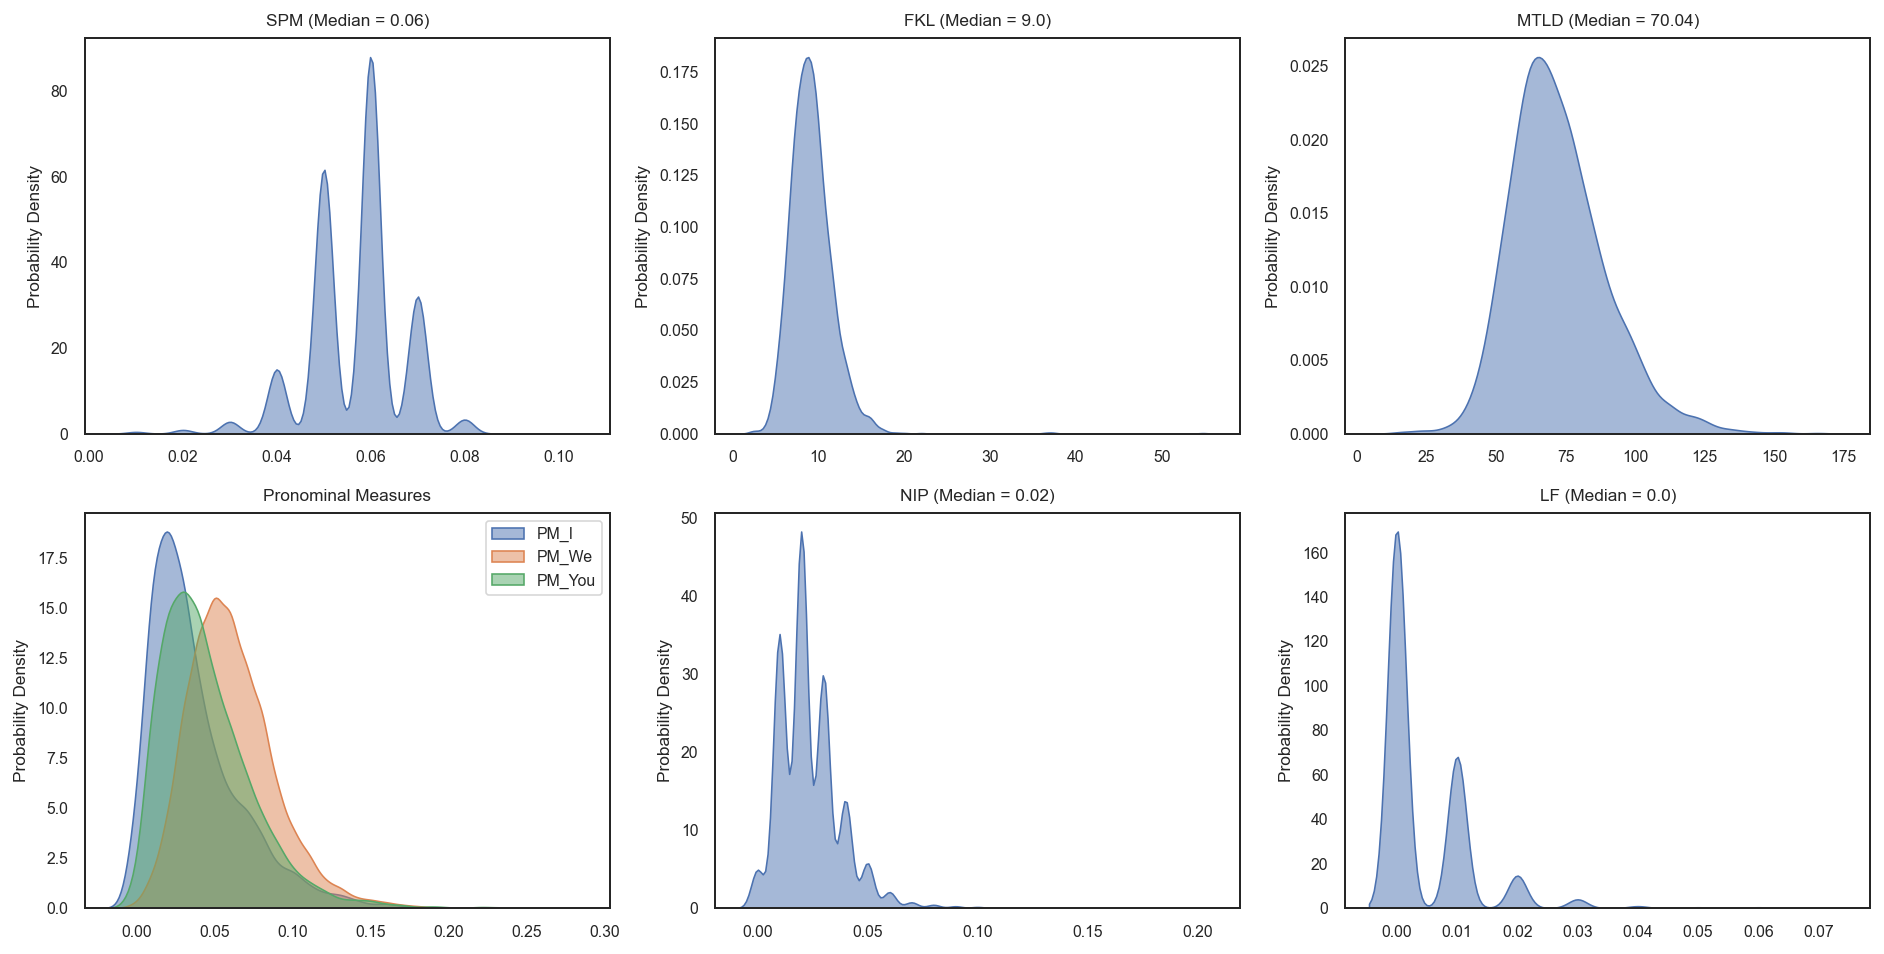

In [115]:
fig, axes = plt.subplots(2, 3, figsize=(16,8))

# spm
sns.kdeplot(ax=axes[0,0], x='spm', data=temp, alpha=0.5, shade=True)
axes[0,0].set_title("SPM (Median = " + str(temp.spm.median()) + ")")
axes[0,0].set_ylabel("Probability Density")
axes[0,0].set_xlabel("")

# fkl
sns.kdeplot(ax=axes[0,1], x='fkl', data=temp, alpha=0.5, shade=True)
axes[0,1].set_title("FKL (Median = " + str(temp.fkl.median()) + ")")
axes[0,1].set_ylabel("Probability Density")
axes[0,1].set_xlabel("")

# mtld
sns.kdeplot(ax=axes[0,2], x='mtld', data=temp, alpha=0.5, shade=True)
axes[0,2].set_title("MTLD (Median = " + str(round(temp.mtld.median(), 2)) + ")")
axes[0,2].set_ylabel("Probability Density")
axes[0,2].set_xlabel("")

# pronominal measures
sns.kdeplot(ax=axes[1,0], x='pm_i', data=temp, alpha=0.5, shade=True, label='PM_I')
axes[1,0].set_ylabel("Probability Density")
axes[1,0].set_xlabel("")
sns.kdeplot(ax=axes[1,0], x='pm_we', data=temp, alpha=0.5, shade=True, label='PM_We')
axes[1,0].set_ylabel("Probability Density")
axes[1,0].set_xlabel("")
sns.kdeplot(ax=axes[1,0], x='pm_you', data=temp, alpha=0.5, shade=True, label='PM_You')
axes[1,0].set_title("Pronominal Measures")
axes[1,0].set_ylabel("Probability Density")
axes[1,0].set_xlabel("")
axes[1,0].legend(labels=["PM_I", "PM_We", "PM_You"])

# nip
sns.kdeplot(ax=axes[1,1], x='nip', data=temp, alpha=0.5, shade=True)
axes[1,1].set_title("NIP (Median = " + str(temp.nip.median()) + ")")
axes[1,1].set_ylabel("Probability Density")
axes[1,1].set_xlabel("")

# lf
sns.kdeplot(ax=axes[1,2], x='lf', data=temp, alpha=0.5, shade=True)
axes[1,2].set_title("LF (Median = " + str(temp.lf.median()) + ")")
axes[1,2].set_ylabel("Probability Density")
axes[1,2].set_xlabel("")

plt.savefig('../reports/figures/'+"measure_dist"+'.png', bbox_inches='tight')

In [68]:
def year_prog(col, label, title):
    """
    Plot year-wise progression of a measure
    """
    plt.figure(figsize=(5,3))
    ax = sns.lineplot(x='p_year', y=col, data=ted)
    ax.set_xticks(np.arange(16))
    ax.set_xticks([2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,          2020, 2021])
    ax.axhline(ted[col].mean(), color='r', ls='--')
    plt.xticks(rotation=45)
    plt.xlim(2006, 2021)
    plt.xlabel('\nYear of Publishing Talk')
    plt.ylabel(label)
    plt.savefig('../reports/figures/'+title+'.png', bbox_inches='tight')

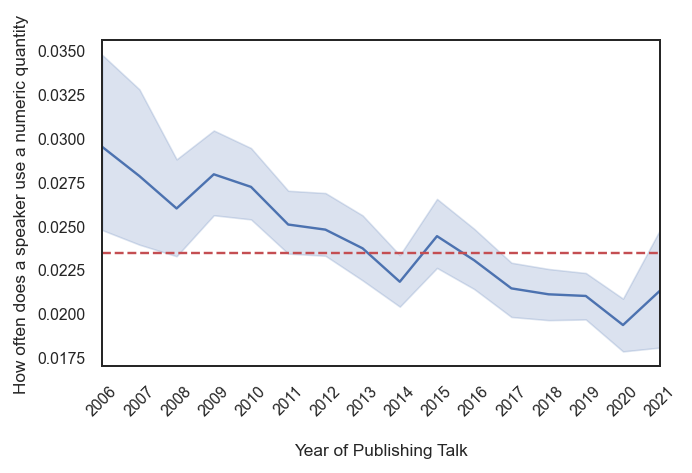

In [84]:
year_prog('nip', 'How often does a speaker use a numeric quantity', 'nip')

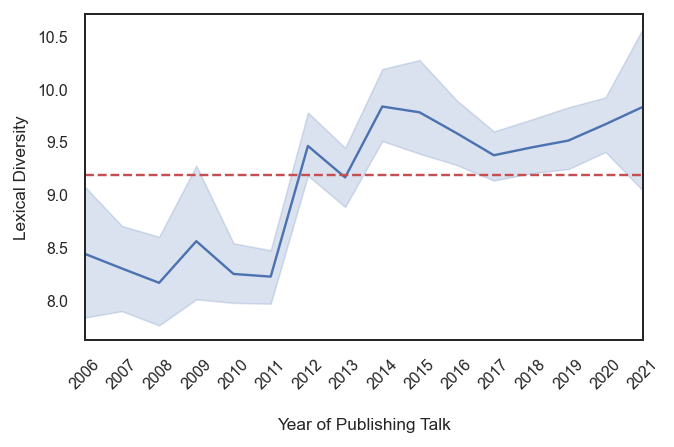

In [76]:
year_prog('fkl', 'Lexical Diversity', 'fkl')

In [116]:
trial = ted[['p_year', 'cnt_laughs', 'cnt_i', 'cnt_we', 'cnt_you', 'nip_comps_cnt']]
trial.columns = ['Year', 'Count_Laughs', 'Count_I', 'Count_We', 'Count_You', 'Count_NIP']
trial.head()

,Year,Count_Laughs,Count_I,Count_We,Count_You,Count_NIP
0,2021,0,8,14,9,19
1,2021,13,28,59,56,25
2,2021,0,12,61,88,25
3,2021,0,19,36,47,11
4,2021,0,16,20,2,9


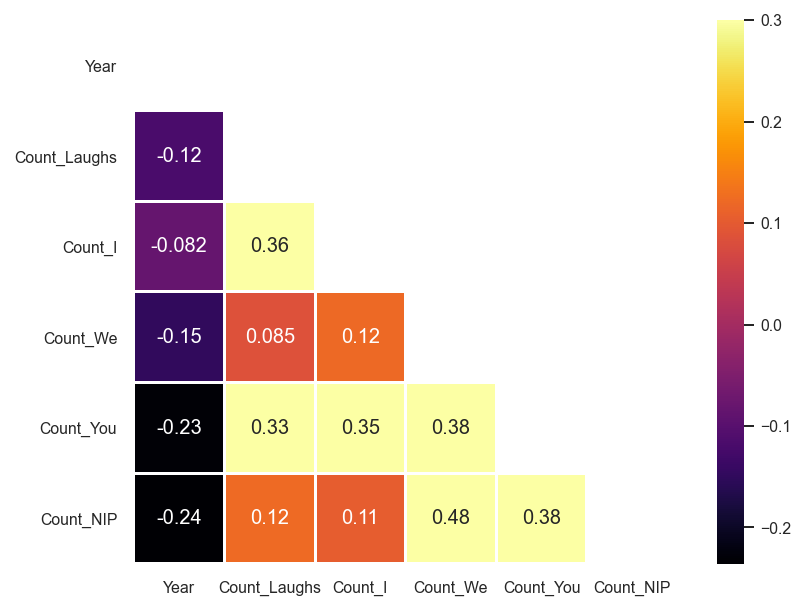

In [120]:
corr = trial.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, annot=True, fmt='.2g', linewidths=1, cmap='inferno')
plt.savefig('../reports/figures/'+"corr.png", bbox_inches='tight')